In [5]:
import os
from scipy.io import wavfile
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight as sklearn_compute_class_weight
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from python_speech_features import mfcc

## Configuration Class
The `Config` class is a central place to manage all configuration settings for the audio classification model. 
It encapsulates various parameters that will be used throughout the data preprocessing and model training processes.


In [6]:
class Config: 
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000): 
        self.mode = mode   # The mode of processing ('conv' for CNN, 'time' for RNN)
        self.nfilt = nfilt # The number of filters in the Mel filterbank
        self.nfeat = nfeat # The number of features to be extracted
        self.nfft = nfft   # The window size for the FFT
        self.rate = rate   # The sample rate of the audio files
        self.step = int(rate/10)  # The step size for feature extraction  

## Model 1 : Convolutional neural network


In [7]:
def get_conv_model(input_shape):
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['acc'])
    return model

## Model 2 : Recurrent neural network (LSTM)

In [8]:
def get_recurrent_model(input_shape) :
    #Shape of data for RNN is (n, time, feat)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['acc'])
    return model

## Class Distribution from the clean wavefiles

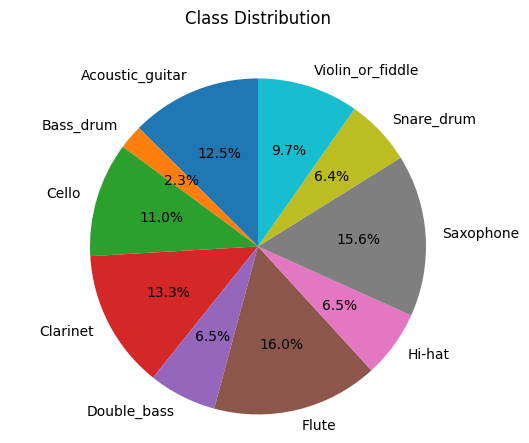

In [9]:
#Model Preparation
df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    # Calculate the duration of the audio file and add it to the dataframe.
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label)) # Extract classes from the dataframe.
class_dist = df.groupby(['label'])['length'].mean() # Compute the average duration of audio files per class.

# Determine the total number of samples to generate, based on the sum of audio lengths and a chosen time frame (0.1 seconds here).
n_samples = 2 * int(df['length'].sum()/0.1) 
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

## Feature Building Function

The `build_rand_feat` function is a key component of the audio processing pipeline. It constructs the feature set for the machine learning model by extracting Mel Frequency Cepstral Coefficients (MFCCs) from the audio files. This function either loads preprocessed data if available or processes raw audio files to generate features.

In [10]:
def build_rand_feat() :
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        # Extract MFCC features from the audio sample.
        X_sample = mfcc(sample ,rate ,numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T

        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    # Normalize the features to be within the range [0, 1].
    X = (X - _min) / (_max - _min)

    # Reshape the feature array based on the model type.
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes=10)
    config.data = (X,y)

    return X, y

## Model Setup and Training

1) Feature Preparation
Before training, we need to prepare our features (the inputs to our model) and our labels (the expected outputs). This is done by the `build_rand_feat()` function.

2) Train/Test Split
To evaluate our model's performance, we need to test it on unseen data. Therefore, we split our dataset into a training set and a testing set. Typically, we allocate 70% of the data for training and 30% for testing, which is accomplished with the `train_test_split` function from `sklearn.model_selection`.

3) Model Definition

4) Model Training
The `train_model` function trains the model using the features and labels of the training set. During training, we use class weights to handle imbalanced datasets, which is a common issue in audio classification tasks. Class weights are calculated using the `compute_class_weights` function, which helps to give more importance to under-represented classes.

5) Callbacks
During training, we use a `ModelCheckpoint` callback to save the best version of the model based on the validation accuracy (`val_acc`). This ensures that we keep the model that performs best on the validation set.

6) Model Saving
After training, we save the model to an HDF5 file (`model.h5`). This file contains the architecture of the model, the model weights, and the training configuration.

In [11]:
def setup_model(config):
    # Build features and labels
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Determine the input shape based on the mode
    if config.mode == 'conv':
        input_shape = (X.shape[1], X.shape[2], 1)
        model = get_conv_model(input_shape)
    elif config.mode == 'time':
        input_shape = (X.shape[1], X.shape[2])
        model = get_recurrent_model(input_shape)
    else:
        raise ValueError("Mode should be either 'conv' or 'time'")

    return X_train, X_test, y_train, y_test, model

def train_model(X_train, y_train, model, config):
    y_flat = np.argmax(y_train, axis=1)
    class_weights = compute_class_weights(y_flat)

    checkpoint = ModelCheckpoint(
        'model.h5', monitor='val_acc', verbose=0,
        mode='max', save_best_only=True, save_weights_only=False, save_freq='epoch'
    )
    
    history = model.fit(
        X_train, y_train, epochs=50, batch_size=32, shuffle=True,
        validation_split=0.2, class_weight=class_weights, callbacks=[checkpoint]
    )
    
    model.save('model.h5')

    return history
    
from collections import Counter
def compute_class_weights(y_flat):
    class_counts = Counter(y_flat)
    total_samples = len(y_flat)
    return {class_label: total_samples / class_count for class_label, class_count in class_counts.items()}


### Conv Training

In [12]:
config = Config(mode='conv')  
X_train, X_test, y_train, y_test, model = setup_model(config)

100%|██████████| 26404/26404 [00:55<00:00, 478.97it/s]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 9, 16)         160       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 9, 32)         4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 9, 64)         18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 9, 128)        73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 4, 128)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 4, 128)         0         
                                                        

In [13]:
history = train_model(X_train, y_train, model, config)

Epoch 1/50
463/463 [==============================] - 17s 33ms/step - loss: 12.3714 - acc: 0.5391 - val_loss: 0.8282 - val_acc: 0.7206
Epoch 2/50
463/463 [==============================] - 15s 33ms/step - loss: 6.5322 - acc: 0.7511 - val_loss: 0.5602 - val_acc: 0.8082
Epoch 3/50
463/463 [==============================] - 16s 34ms/step - loss: 4.7624 - acc: 0.8162 - val_loss: 0.6044 - val_acc: 0.7890
Epoch 4/50
463/463 [==============================] - 16s 35ms/step - loss: 3.8765 - acc: 0.8493 - val_loss: 0.3524 - val_acc: 0.8815
Epoch 5/50
463/463 [==============================] - 15s 33ms/step - loss: 3.1060 - acc: 0.8799 - val_loss: 0.2809 - val_acc: 0.9048
Epoch 6/50
463/463 [==============================] - 16s 35ms/step - loss: 2.9131 - acc: 0.8893 - val_loss: 0.3142 - val_acc: 0.8859
Epoch 7/50
463/463 [==============================] - 16s 34ms/step - loss: 2.3960 - acc: 0.9082 - val_loss: 0.3165 - val_acc: 0.8888
Epoch 8/50
463/463 [==============================] - 16s 35m

### Accuracy and Loss Plots

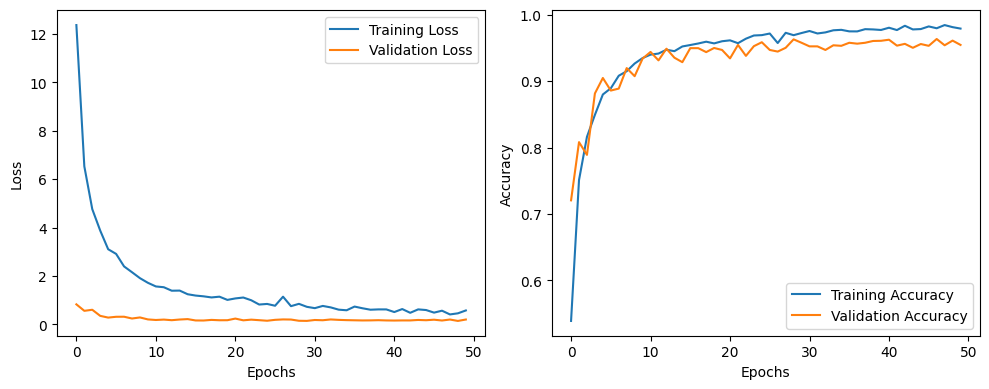

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.1950
Test Accuracy: 0.9541


### LSTM Training

In [16]:
config = Config(mode='time')  
X_train, X_test, y_train, y_test, model = setup_model(config)
history = train_model(X_train, y_train, model, config)

100%|██████████| 26404/26404 [00:57<00:00, 458.74it/s] 


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 13, 128)           70656     
                                                                 
 lstm_1 (LSTM)               (None, 13, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 13, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 13, 64)           8256      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 13, 32)           2080      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 13, 16)          

: 

### Accuracy and Loss Plots

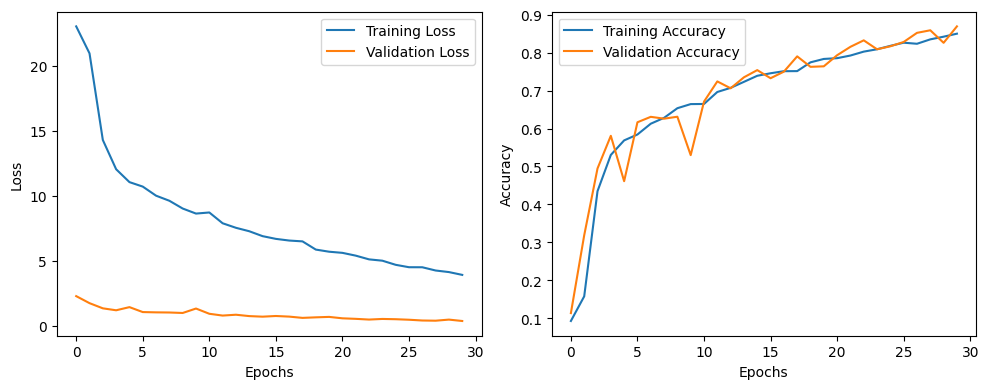

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.2073
Test Accuracy: 0.9328


### ROC Curve